In [1]:
import yfinance as yf 
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import random
from IPython.display import clear_output
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Get data

In [2]:
start_date = '2020-04-13'
end_date = datetime.datetime.now()

ticker_list = ['AAPL', 'AMZN','PEP', 'SONY', 'TSLA', 'PYPL']

all_data = yf.download(ticker_list, start_date, end_date)
all_prices = all_data['Adj Close']
all_prices = all_prices.reset_index(inplace=False)
all_prices = all_prices.set_index('Date')

capm_data = yf.download(['SPY','^TNX'], start_date, end_date)
capm_data = capm_data['Adj Close']
capm_data.columns = ['SPY', 'Rf']
#print(all_prices.tail(3))

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  2 of 2 completed


# Decide on Amount of Days Per Rebalance

In [3]:
split_size = 15

## Split data into chunks to rebalance port every x days

In [4]:
def splitDataFrameIntoSmaller(df, chunksize):
    list_of_df = list()
    no_chunks = (len(df) // chunksize)
    for i in range(no_chunks):
        list_of_df.append(df[i*chunksize:(i+1)*chunksize])
    return list_of_df


date_chunks = splitDataFrameIntoSmaller(all_prices, split_size)
capm_chunks = splitDataFrameIntoSmaller(capm_data, split_size)
No_Updates = len(date_chunks)
print(len(date_chunks))

31


In [5]:
date_chunks[1].index[0]

Timestamp('2020-05-04 00:00:00')

In [6]:
# Function to get portfolio with minimum weightings in each stock
def get_diversified_port():
    column_names = portfolios.columns
    stock_columns = list(column_names[2:-1])
    min_weight = 1/(len(stock_columns) * 3)
    # Make sure each stock has minimum weight in portofolio comp
    chosen_weightings = portfolios[(portfolios[stock_columns] > min_weight)][stock_columns].dropna()
    trimmed = portfolios.loc[chosen_weightings.index]
    # Best 5 portfolios with min weight
    best_weights = trimmed.nlargest(5, 'Sharpe')
    best_weights['P Weight Var'] = best_weights.iloc[:,2:-1].var(axis=1)
    # Choose most balanced of top 5
    diversified = (best_weights[best_weights['P Weight Var']==best_weights['P Weight Var'].min()])
    diversified = diversified.iloc[:,:-1]
    return diversified

In [7]:
def capm_returns(data):
    capm_data = data
    capm_returns = capm_data.pct_change().dropna()
    beta = {}
    alpha = {}
    for i in returns.columns:
        b, a = np.polyfit(capm_returns['SPY'], returns.dropna()[i], 1)
        beta[i] = b    
        alpha[i] = a  
    keys = list(beta.keys())
    ER = (returns.mean())
    rf = .02 
    rm = capm_data['SPY'].pct_change().mean() * 252 
    for i in keys:
      ER[i] = rf + (beta[i] * (rm-rf)) 
    return ER

## Use loop to find optimal sharpe ratio portfolio at each interval and store portfolio weightings

In [8]:
optimal_weights = pd.DataFrame()
max_sharpe_weights = pd.DataFrame()
type(optimal_weights)
for i in range(0,(No_Updates)):
    clear_output(wait=True)
    # Establish used prices as current iteration of df list
    prices = date_chunks[i]
    capm = capm_chunks[i]
    # Calc returns
    returns = prices.pct_change()
    # Create cov and corr matrices
    cov_matrix = returns.apply(lambda x: np.log(1+x)).cov()
    corr_matrix = returns.apply(lambda x: np.log(1+x)).corr()
    # Establish expected returns
    er = capm_returns(capm)
    # Prepare loop of portfolio creation
    p_ret=[]
    p_vol=[]
    p_weights = []
    mean_variance_pairs = {}

    num_assets = len(returns.columns)
    num_portfolios = int(500*1.2**(num_assets))
    for portfolio in range(num_portfolios):
        clear_output(wait=True)
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        rets = round(np.dot(weights, er), 4)
        volatility = round(np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))), 4)
        mean_variance_pairs[rets] = volatility
        # Always add first portfolio
        if portfolio == 0:
            p_ret.append(rets)
            p_vol.append(volatility)
            p_weights.append(weights)
            continue
        else:
            # Test and chuck bad portfolios
            new_port = True
            for (R, V) in mean_variance_pairs.items():
                    if (R > rets*1.05) & (V < volatility*.95):
                        new_port = False
                        continue
                    else:
                        pass
            if new_port:
                p_ret.append(rets)
                p_vol.append(volatility)
                p_weights.append(weights)
            else:
                pass
            #print('Current portfolio progress:', np.round(portfolio/num_portfolios *100, 2), '%')
            #print('Total progress:', np.round(i/No_Updates *100, 2), '%')
        
    data1 = {'Returns': p_ret, 'Volatility': p_vol}
    for counter, symbol in enumerate(returns.columns.tolist()):
        data1[symbol+ ' Weight'] = [w[counter] for w in p_weights]
    portfolios = pd.DataFrame(data1)
    rf_data = yf.download('^TNX', prices.index[0], prices.index[-1])
    rf_returns = rf_data['Adj Close']
    rfr = (rf_returns.mean())/100 # divide by 100 to convert to x percent
    portfolios['Sharpe']=(portfolios['Returns']-rfr)/portfolios['Volatility']
    # Choose portfolios to use
    chosen = get_diversified_port()
    sharpe = portfolios[portfolios['Sharpe']==portfolios['Sharpe'].max()]
    optimal_weights = pd.concat([optimal_weights, chosen])
    max_sharpe_weights = pd.concat([max_sharpe_weights, sharpe])
    
    
opt_weights = optimal_weights.iloc[:,2:-1]
opt_weights = opt_weights.values

sharpe_weights = max_sharpe_weights.iloc[:,2:-1]
sharpe_weights = sharpe_weights.values

[*********************100%***********************]  1 of 1 completed


In [9]:
sharpe_weights = max_sharpe_weights.iloc[:,2:-1]
sharpe_weights = sharpe_weights.values


# Establish positions and portfolio df's

In [10]:
positions = pd.DataFrame()
portfolio = pd.DataFrame()
initial_capital = [100000.0]
# Subtract one from range and add one to date_chunks indexing to use weights
# against future prices
for i in range(0,(No_Updates-1)):
    # Establish used prices as current iteration of df list
    prices = date_chunks[i+1]
    pos = pd.DataFrame(index=prices.index).fillna(0.0)
    for counter, symbol in enumerate(all_prices.columns.tolist()):
        pos[symbol+ ' Shares'] = ((opt_weights[i][counter]*initial_capital[i])/prices.iloc[0,counter])
       
    positions = pd.concat([positions, pos])
    col_list= []
    for counter, symbol in enumerate(all_prices.columns.tolist()):
        col_list.append(symbol+ ' Value')
    # Initialize portfolio
    port = pd.DataFrame(prices.values*pos.values, columns=col_list, index=pos.index)
    port['total'] = port.sum(axis=1)
    initial_capital.append(port['total'][-1])
    portfolio = pd.concat([portfolio, port])
portfolio['returns'] = portfolio['total'].pct_change()
portfolio

,AAPL Value,AMZN Value,PEP Value,PYPL Value,SONY Value,TSLA Value,total,returns
Date,,,,,,,,
2020-05-04,16780.270184,8465.876734,16426.926982,26246.929610,21658.469189,10421.527302,100000.000000,NaN
2020-05-05,17032.121497,8472.493227,16521.031284,26622.612741,22165.488846,10517.638241,101331.385836,0.013314
2020-05-06,17207.845799,8594.802869,16409.363061,27233.894343,22361.303711,10714.379879,102521.589662,0.011746
2020-05-07,17385.859756,8654.569065,16505.977214,31050.162079,22508.165193,10679.603746,106784.337054,0.041579
2020-05-08,17799.670885,8698.433900,16842.242852,30767.871420,22906.787121,11218.759668,108233.765847,0.013573
...,...,...,...,...,...,...,...,...
2022-02-07,40820.680158,59260.650622,50244.900332,11736.708596,23308.615386,12843.958107,198215.513201,-0.004046
2022-02-08,41574.504454,60565.668931,50306.315654,11625.537915,23312.862257,13051.479075,200436.368285,0.011204
2022-02-09,41919.313148,60481.619885,50282.919553,11884.613623,23671.783595,13193.035247,201433.285051,0.004974


In [11]:
positions2 = pd.DataFrame()
portfolio2 = pd.DataFrame()
initial_capital = [100000.0]
# Subtract one from range and add one to date_chunks indexing to use weights
# against future prices
for i in range(0,(No_Updates-1)):
    # Establish used prices as current iteration of df list
    prices = date_chunks[i+1]
    pos = pd.DataFrame(index=prices.index).fillna(0.0)
    for counter, symbol in enumerate(all_prices.columns.tolist()):
        pos[symbol+ ' Shares'] = ((sharpe_weights[i][counter]*initial_capital[i])/prices.iloc[0,counter])
       
    positions2 = pd.concat([positions2, pos])
    col_list= []
    for counter, symbol in enumerate(all_prices.columns.tolist()):
        col_list.append(symbol+ ' Value')
    # Initialize portfolio2
    port = pd.DataFrame(prices.values*pos.values, columns=col_list, index=pos.index)
    port['total'] = port.sum(axis=1)
    initial_capital.append(port['total'][-1])
    portfolio2 = pd.concat([portfolio2, port])
portfolio2['returns'] = portfolio2['total'].pct_change()
portfolio2

,AAPL Value,AMZN Value,PEP Value,PYPL Value,SONY Value,TSLA Value,total,returns
Date,,,,,,,,
2020-05-04,4577.870297,2262.458166,26380.560907,25346.396187,32473.076241,8959.638203,100000.000000,NaN
2020-05-05,4646.578526,2264.226387,26531.686208,25709.189611,33233.263299,9042.267094,101427.211124,0.014272
2020-05-06,4694.518342,2296.912954,26352.354409,26299.498112,33526.853349,9211.410622,102381.547787,0.009409
2020-05-07,4743.082804,2312.885135,26507.510365,29984.829518,33747.046386,9181.512742,106476.866950,0.040001
2020-05-08,4855.975723,2324.607767,27047.530792,29712.224265,34344.710059,9645.038084,107930.086689,0.013648
...,...,...,...,...,...,...,...,...
2022-02-07,17377.097702,1714.741905,79616.001305,6565.077166,42990.010263,1815.614564,150078.542905,-0.002814
2022-02-08,17697.995796,1752.503380,79713.317497,6502.892432,42997.843119,1844.949609,150509.501833,0.002872
2022-02-09,17844.778611,1750.071372,79676.244999,6647.809723,43659.831477,1864.959909,151443.696090,0.006207


In [12]:
PortfolioSections = portfolio.reset_index(inplace=False)
PortfolioSections = PortfolioSections[PortfolioSections.index % split_size == 0]  # Selects every n'th row excluding 0
PortfolioSections = PortfolioSections.set_index('Date')
PortfolioSections['returns'] = PortfolioSections['total'].pct_change()
port_cols = list(PortfolioSections.columns)
format_dict = {port_cols[0]:'${0:,.0f}' , port_cols[1]:'${0:,.0f}' , port_cols[2]:'${0:,.0f}' , port_cols[3]:'${0:,.0f}' , port_cols[4]:'${0:,.0f}', 'total':'${0:,.0f}','returns': '{:.2%}'}
print('Portfolio Value at End Of Ea Rebalance:')
PortfolioSections.style.format(format_dict)

Portfolio Value at End Of Ea Rebalance:


,AAPL Value,AMZN Value,PEP Value,PYPL Value,SONY Value,TSLA Value,total,returns
Date,,,,,,,,
2020-05-04 00:00:00,"$16,780","$8,466","$16,427","$26,247","$21,658",10421.527302,"$100,000",nan%
2020-05-26 00:00:00,"$28,850","$22,534","$12,608","$10,972","$14,134",19801.380506,"$108,899",8.90%
2020-06-16 00:00:00,"$13,045","$19,452","$29,157","$22,505","$27,873",7495.371247,"$119,527",9.76%
2020-07-08 00:00:00,"$35,121","$14,006","$29,524","$16,429","$12,628",21143.590066,"$128,851",7.80%
2020-07-29 00:00:00,"$32,574","$8,290","$39,994","$22,903","$13,392",13904.276599,"$131,059",1.71%
2020-08-19 00:00:00,"$38,373","$21,045","$32,105","$12,582","$17,559",22941.728594,"$144,605",10.34%
2020-09-10 00:00:00,"$22,777","$19,887","$42,458","$19,979","$30,927",8334.164273,"$144,362",-0.17%
2020-10-01 00:00:00,"$15,071","$37,961","$40,335","$10,897","$27,677",16056.451442,"$147,997",2.52%
2020-10-22 00:00:00,"$39,487","$39,397","$24,896","$21,529","$10,681",10568.149396,"$146,558",-0.97%


## Plot frequency of returns for rebalances

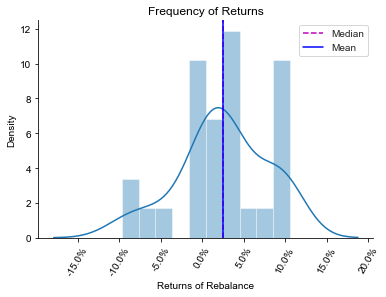

In [13]:
fig, ax0 = plt.subplots()
sns.set_style('white')
sns.set_palette('bright')
sns.despine()

rebalance_returns = PortfolioSections['returns']

sns.distplot(rebalance_returns, kde=True, bins=10, ax=ax0)
ax0.set(xlabel = 'Returns of Rebalance', title='Frequency of Returns')

ax0.axvline(x=rebalance_returns.median(), color='m', label='Median', linestyle='--')
ax0.axvline(x=rebalance_returns.mean(), color='b', label='Mean', linestyle='-')

ax0.xaxis.label.set_color('black')
ax0.yaxis.label.set_color('black')
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis='y', colors='black')

ax0.xaxis.set_major_locator(plt.MaxNLocator(10))
vals = ax0.get_xticks()
ax0.set_xticklabels(['{:,.1%}'.format(x) for x in vals])
plt.xticks(rotation=60)

ax0.legend()
plt.show()

## Show average portfolio balance

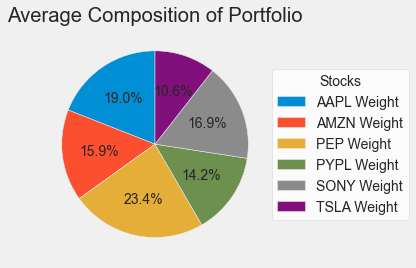

In [14]:
rebalance_weights = optimal_weights.iloc[:-1,2:-1]

#print(rebalance_weights.shape)
#print(PortfolioSections.shape)
avg_portfolio_composition = rebalance_weights.mean()
plt.style.use('fivethirtyeight')
fig1, ax1 = plt.subplots()
ax1.set(title='Average Composition of Portfolio')
ax1.pie(avg_portfolio_composition, autopct='%1.1f%%', startangle=90)
plt.legend(title='Stocks', bbox_to_anchor=(1.0,0.5), loc="center left", borderaxespad=0, facecolor='white', labels=avg_portfolio_composition.index)
plt.show()

# Get index data for comparison

In [15]:
index_data = yf.download('^GSPC', date_chunks[1].index[0], end_date)
index_data['returns'] = index_data['Adj Close'].pct_change()

portfolio['Std Value'] = portfolio['total'] / portfolio['total'].iloc[0] * 100
index_data['Std Value'] = index_data['Adj Close'] / index_data['Adj Close'].iloc[0] * 100
portfolio2['Std Value'] = portfolio2['total'] / portfolio2['total'].iloc[0] * 100

[*********************100%***********************]  1 of 1 completed


# Plot Results


Current portfolio value is: $193,132.98
Portfolio annualized return is: 44.15%
Index annualized return is: 28.46%


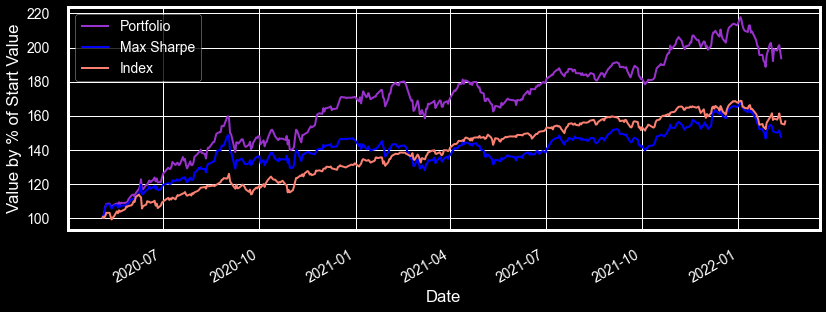

In [16]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(12,10))
fig.patch.set_facecolor('black')
ax1 = fig.add_subplot(211, ylabel='Value by % of Start Value')
portfolio['Std Value'].plot(ax=ax1, color='darkorchid', lw=2.)
portfolio2['Std Value'].plot(ax=ax1, color='blue', lw=2.)
index_data['Std Value'].plot(ax=ax1, color='salmon', lw=2.)
legend_labels = ['Portfolio', 'Max Sharpe', 'Index']
plt.legend(labels=legend_labels)

# Add ticks for portfolio rebalance
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, split_size), minor=True)
ax1.tick_params(which='major', length= 15, width=2)
ax1.tick_params(which='minor', length= 5, color='grey')

# Get final value of portfolio
portfolio_value = (portfolio.iloc[-1,-3])
# Calc cumulative returns of port and index
cum_port_change = (1+portfolio['returns']).cumprod()
cum_index_change = (1+index_data['returns']).cumprod()
# Annualize
portfolio_cum_ret = (cum_port_change**(250/len(portfolio.index)))-1
index_cum_ret = (cum_index_change**(250/len(index_data.index)))-1
# Slice most recent date
portfolio_ret= portfolio_cum_ret[-1]
index_ret = index_cum_ret[-1]

print('\nCurrent portfolio value is: $'+ str('{:,.2f}'.format(portfolio_value)))
print('Portfolio annualized return is: '+ str("{:.2%}".format(portfolio_ret)))
print('Index annualized return is: '+ str("{:.2%}".format(index_ret)))
plt.show()

In [17]:
PortfolioSections.to_excel("PortfolioUpdates.xlsx")
portfolio.to_excel("Portfolio.xlsx")
optimal_weights.to_excel("PortWeights.xlsx")
all_prices.to_excel("StockPrices.xlsx")
index_data.to_excel("IndexData.xlsx")